In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime

from scipy.stats import shapiro
from scipy.stats import kruskal
from feature_engine.outliers import Winsorizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import KNNImputer

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from scipy.stats import chi2_contingency

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
df_raw = pd.read_csv('3A.tsv', sep='\t')
df_raw.head()

,index,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,0,Wii Sports,Wii,2006,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,1,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,-706.0,NaN,NaN
2,2,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,3,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,-92.0,NaN,NaN


### A. EDA

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16928 entries, 0 to 16927
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            16928 non-null  int64  
 1   Name             16926 non-null  object 
 2   Platform         16928 non-null  object 
 3   Year_of_Release  16928 non-null  int64  
 4   Genre            16926 non-null  object 
 5   Publisher        16873 non-null  object 
 6   NA_Sales         16928 non-null  float64
 7   EU_Sales         16928 non-null  float64
 8   JP_Sales         16928 non-null  float64
 9   Other_Sales      16928 non-null  float64
 10  Global_Sales     16928 non-null  float64
 11  Critic_Score     8260 non-null   float64
 12  Critic_Count     8260 non-null   float64
 13  User_Score       10159 non-null  object 
 14  User_Count       16928 non-null  float64
 15  Developer        10240 non-null  object 
 16  Rating           10092 non-null  object 
dtypes: float64(8

The User_Score column has an incorrect data type (object) instead of a numerical type

| **Variable**      | **Description**                                                                 |
|-------------------|---------------------------------------------------------------------------------|
| **Index**         | Row index of the game in the table                                               |
| **Name**          | The name of the game                                                             |
| **Platform**      | The platform for which the game was made                                         |
| **Year_of_Release** | The year in which the game was released                                         |
| **Genre**         | The genre of the game                                                            |
| **Publisher**     | The game’s publisher                                                              |
| **NA_Sales**      | Number of copies sold in North America (millions)                                |
| **EU_Sales**      | Number of copies sold in Europe (millions)                                       |
| **JP_Sales**      | Number of copies sold in Japan (millions)                                        |
| **Other_Sales**   | Number of copies sold in other countries (millions)                              |
| **Global_Sales**  | The total number of copies sold globally (millions)                             |
| **Critic_Score**  | The average score given by game critics (0-100)                                  |
| **Critic_Count**  | The number of game critics that reviewed the game                                |
| **User_Score**    | The average score given by users (0-10)                                          |
| **User_Count**    | The number of users playing the game                                            |
| **Developer**     | The game’s developer                                                             |
| **Rating**        | The ESBR categorization of the game (such as E=Everyone, T=Teen, M=Mature, etc.) |

In [4]:
# Convert 'User_Score' to float, coercing errors to NaN
df_raw['User_Score'] = pd.to_numeric(df_raw['User_Score'], errors='coerce')

In [5]:
# Remove duplicate data
print(df_raw.duplicated().sum())
df_raw = df_raw.drop_duplicates().reset_index(drop=True)

0


There are no duplicate rows

In [6]:
# Remove 'index' as it is not necessary for analysis
df_raw = df_raw.drop(columns=['index'])
df_raw.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,-706.0,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,-92.0,NaN,NaN


In [7]:
# Provides summary statistics for numerical columns
df_raw.describe()

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
count,16928.000000,16928.000000,16928.000000,16928.000000,16928.000000,16928.000000,8260.000000,8260.000000,7718.000000,16928.000000
mean,1974.215147,0.266390,0.146850,0.078170,0.047861,0.539520,69.037893,26.428692,7.125926,-195.792120
std,252.128480,0.814326,0.504585,0.308756,0.186675,1.550545,13.943198,18.989929,1.498886,545.393536
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,0.000000,-1000.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000,60.000000,12.000000,6.400000,-538.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000,71.000000,22.000000,7.500000,-82.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.040000,0.490000,79.000000,36.000000,8.200000,21.000000
max,2020.000000,41.360000,28.960000,10.220000,10.570000,82.530000,98.000000,113.000000,9.700000,10665.000000


1. Year_of_Release: Ranges from year 1 to 2020, with a mean of 1974 and a wide spread
2. NA_Sales: Average of 0.266 million, with a high variability in sales, ranging from 0 to 41.36 million
3. EU_Sales: Average of 0.146 million, sales range from 0 to 28.96 million, with moderate variability
4. JP_Sales: Average of 0.078 million, sales range from 0 to 10.22 million, with moderate spread
5. Other_Sales: Average of 0.048 million, with sales ranging from 0 to 10.57 million and a low spread
6. Global_Sales: Average of 0.540 million, global sales range from 0.01 to 82.53 million with high variability
7. Critic_Score: Average score of 69.04, with a range from 13 to 98 and missing data for many games
8. Critic_Count: Average of 26.43 critics per game, ranging from 3 to 113 critics, with missing data for many games
9. User_Score: Average user score of 7.13, ranging from 0 to 9.7, with many missing entries
10. User_Count: Average of -195.79 users, with negative values suggesting data issues and a wide range

- Missing Values: Several columns have missing values, particularly Critic_Score, Critic_Count, and User_Score. This suggests that a significant portion of the games might not have critic or user reviews.
- Abnormal Values: 
  - The User_Count column contains negative values, which likely indicates data issues or incorrect entries.
  - The Year_of_Release starts from 1, which seems unrealistic, suggesting that some data might be incorrectly recorded.
- Sales Distributions: Sales data varies greatly, with some games having very low sales while others have millions in sales. This variability may indicate the presence of a few extremely popular games.


In [8]:
# Provides summary statistics for categorical columns
df_raw.describe(include='object')

,Name,Platform,Genre,Publisher,Developer,Rating
count,16926,16928,16926,16873,10240,10092
unique,11562,31,12,581,1696,8
top,Need for Speed: Most Wanted,PS2,Action,Electronic Arts,Ubisoft,E
freq,12,2188,3410,1389,206,4043


1. Name: There are 16,926 entries with 11,562 unique game names, and "Need for Speed: Most Wanted" is the most frequent, appearing 12 times.
2. Platform: The dataset has 16,928 entries with 31 unique platforms, and "PS2" is the most common platform, appearing 2,188 times.
3. Genre: There are 16,926 entries with 12 unique genres, and "Action" is the most frequent genre, appearing 3,410 times.
4. Publisher: With 16,873 entries, there are 581 unique publishers, and "Electronic Arts" is the most frequent publisher, appearing 1,389 times.
5. Developer: There are 10,240 entries with 1,696 unique developers, and "Ubisoft" is the most frequent developer, appearing 206 times.
6. Rating: The dataset has 10,092 entries with 8 unique ratings, and "E (Everyone)" is the most frequent, appearing 4,043 times.

- Missing Data: Columns such as Publisher, Developer, and Rating have missing values, with Publisher and Developer having a significant number of missing values.
- Most Frequent Entries: The most common game name, platform, and genre are "Need for Speed: Most Wanted", "PS2", and "Action" respectively, indicating that these elements are highly repeated in the dataset.
- Diversity: There is a good level of diversity in the platforms and developers, with 31 unique platforms and 1,696 unique developers.
- Ratings: The dataset shows a heavy concentration of games rated as "E" (Everyone), suggesting that this rating is the most common among the games in the dataset.

In [9]:
# Group by 'Name', count occurrences, filter for duplicates, and count the number of duplicate game names
df_raw.groupby('Name').size()[df_raw.groupby('Name').size() > 1].sort_values(ascending=False)

Name
Need for Speed: Most Wanted                   12
Madden NFL 07                                 10
Ratatouille                                    9
LEGO Jurassic World                            9
LEGO Marvel Super Heroes                       9
                                              ..
Kuroko's Basketball: Miracle Game              2
Kung Fu Panda: Legendary Warriors              2
Konami Collector's Series: Arcade Advanced     2
Knockout Kings 2002                            2
uDraw Studio: Instant Artist                   2
Length: 2900, dtype: int64

In [10]:
# Numerical columns
num_cols = ['Year_of_Release', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 
            'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count']

# Categorical columns
cat_cols = ['Name', 'Platform', 'Genre', 'Publisher', 'Developer', 'Rating']

Year_of_Release


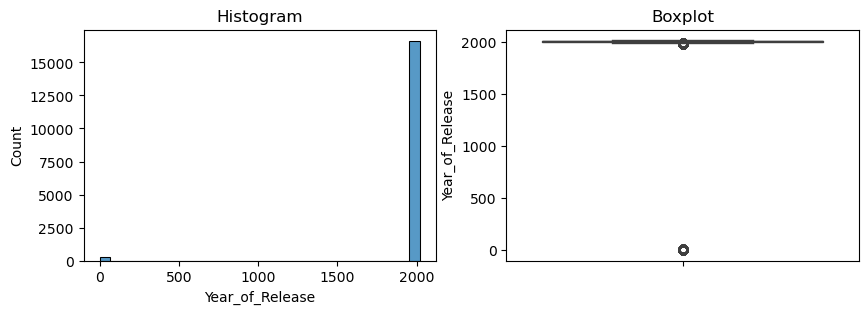

Skewness: -7.67702846117491
Kurtosis: 56.977161205357206
NA_Sales


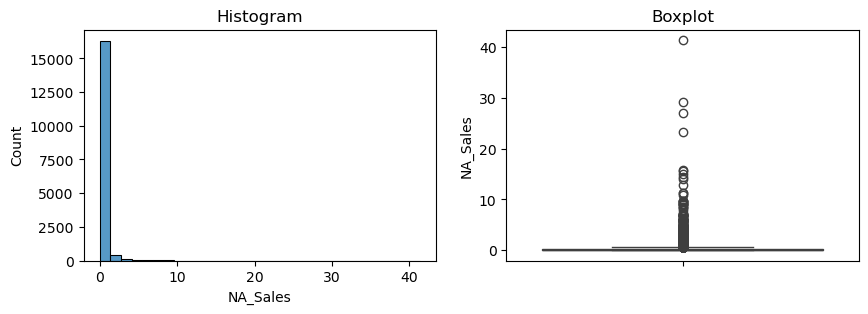

Skewness: 18.531847914202704
Kurtosis: 638.0492271302879
EU_Sales


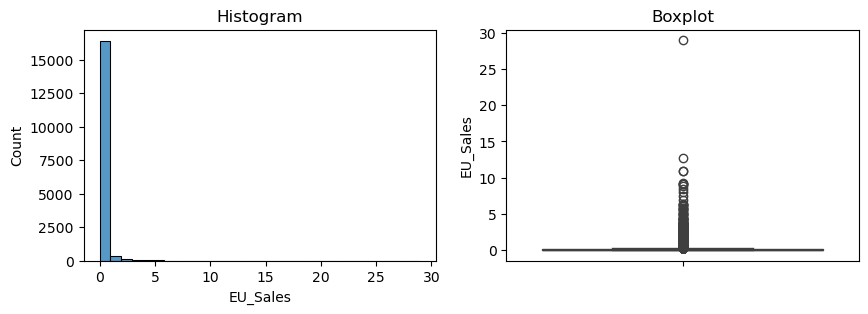

Skewness: 18.546629941510762
Kurtosis: 738.7388153331107
JP_Sales


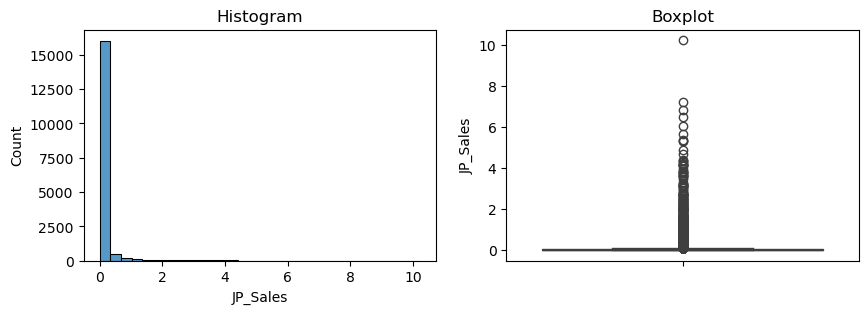

Skewness: 11.117582905705435
Kurtosis: 192.18696226343476
Other_Sales


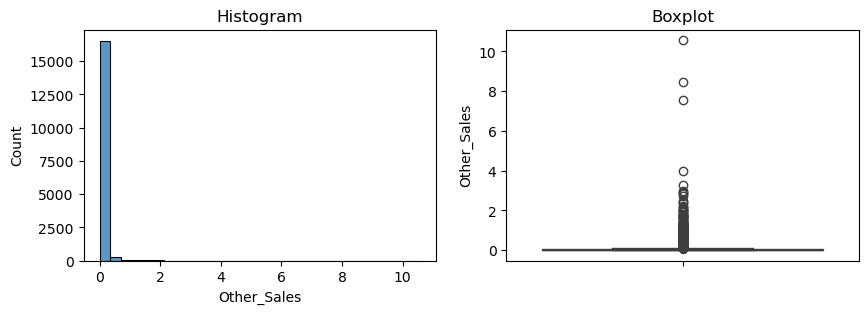

Skewness: 24.339496019105848
Kurtosis: 1042.8170488249298
Global_Sales


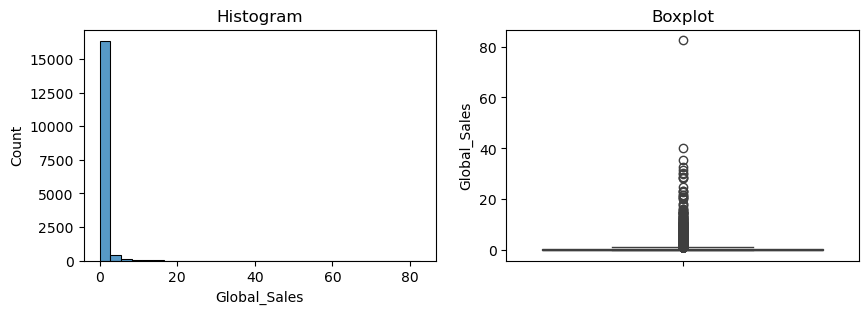

Skewness: 17.130208166202742
Kurtosis: 592.5802416769268
Critic_Score


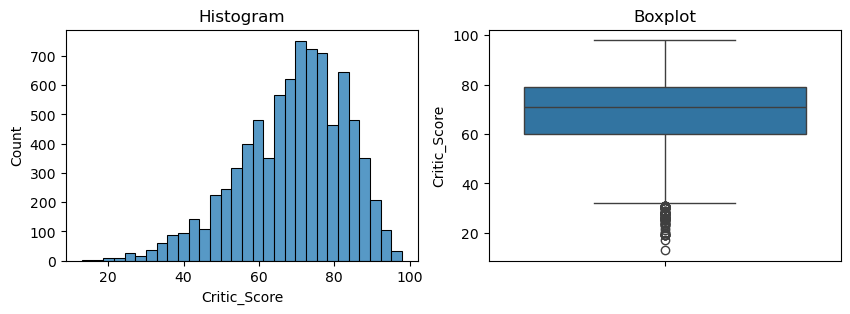

Skewness: -0.6141110228937384
Kurtosis: 0.1393670617448728
Critic_Count


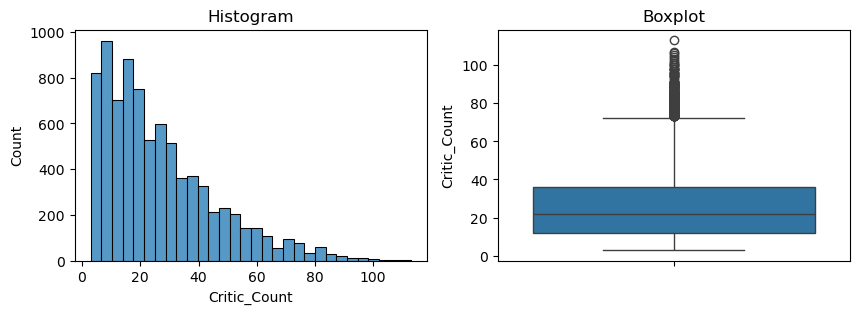

Skewness: 1.149353267105167
Kurtosis: 1.0146351689942432
User_Score


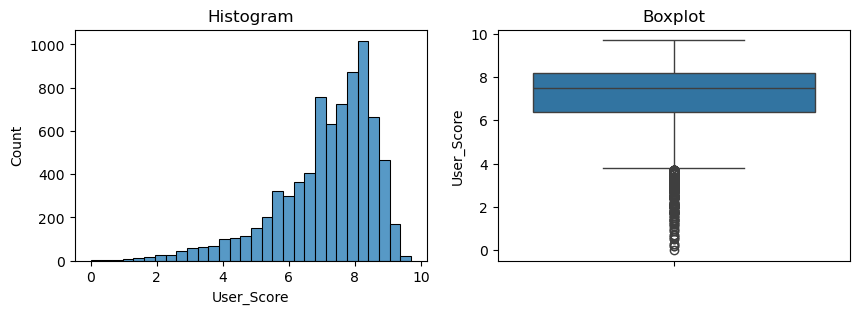

Skewness: -1.2494858790861902
Kurtosis: 1.7074810344972442
User_Count


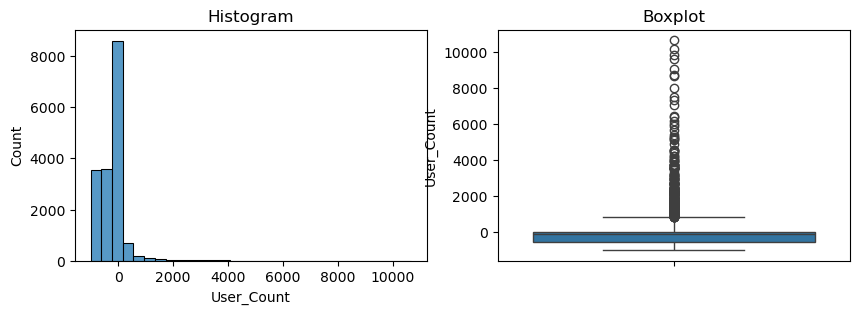

Skewness: 5.222681149412475
Kurtosis: 69.0481242297435


In [11]:
# Input: a pandas DataFrame containing the dataset, columns - A list of numerical columns to analyze
# Process: generates histograms and boxplots for each specified numerical column and calculates the skewness and kurtosis for those columns
# Output: displays histograms and boxplots for each numerical column and prints the skewness and kurtosis values for each

def check_distribution_outliers(df, columns):
    for col in columns:
        print(col)
        plt.figure(figsize=(10, 3))

        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(df[col], bins=30)
        plt.title('Histogram')

        # Boxplot
        plt.subplot(1, 2, 2)
        sns.boxplot(y=df[col])
        plt.title('Boxplot')

        plt.show()

        # Calculate and print skewness and kurtosis
        print('Skewness:', df[col].skew())
        print('Kurtosis:', df[col].kurt())

check_distribution_outliers(df_raw, num_cols)

1. Year_of_Release: The distribution shows most games released around the year 2000, with some erroneous early release years.
2. NA_Sales: Sales in North America are mostly low, with a few games having extremely high sales.
3. EU_Sales: Sales in Europe are similarly low, with a small number of games showing higher sales.
4. JP_Sales: Sales in Japan are concentrated around low values, with a few games showing higher sales.
5. Other_Sales: Most games have minimal sales in other regions, with a few having significantly higher sales.
6. Global_Sales: The majority of games have low global sales, while a few games perform exceptionally well globally.
7. Critic_Score: Critic scores are fairly balanced, with a concentration around 70, but some outliers exist.
8. Critic_Count: Most games have a small number of critics, with a few having a large number of reviews.
9. User_Score: User scores are skewed toward higher values, with some outliers showing low scores.
10. User_Count: User counts are highly skewed, with most games having low user numbers, and a few with a very high number of users.

- For most sales columns (NA, EU, JP, Other, and Global), the distributions are heavily skewed, indicating that most games have very low sales in each region with a few games having exceptionally high sales.
- Critic_Score and User_Score show more balanced distributions with some outliers, suggesting there is variability in how critics and users perceive the games, but most games fall within a moderate range.
- User_Count and Critic_Count show significant outliers at the high end, suggesting that some games have a disproportionately large number of users and critics.

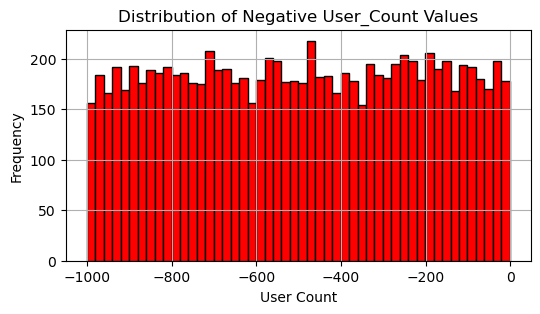

In [12]:
# Filter the data to include only negative values in the 'User_Count' column
negative_user_counts = df_raw[df_raw['User_Count'] < 0]['User_Count']

# Plot the distribution of negative User_Count values using a histogram
plt.figure(figsize=(6, 3))
plt.hist(negative_user_counts, bins=50, color='red', edgecolor='black')
plt.title('Distribution of Negative User_Count Values')
plt.xlabel('User Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [13]:
# Drop the rows where 'User_Count' has negative values
df_raw = df_raw[df_raw['User_Count'] >= 0]

In [14]:
# Filter out rows where 'Year_of_Release' is earlier than 1950 (start of the modern video game industry)
df_raw = df_raw[df_raw['Year_of_Release'] > 1950]

In [15]:
# Input: a pandas DataFrame to analyze for missing values
# Process: calculates the number of missing values and their percentage in each column of the DataFrame
# Output: prints a table showing the column names, number of missing values, and percentage of missing values for each column

def check_na_count (df):
    # Calculate the number of missing values in each column
    missing_values = df.isna().sum()
    # Calculate the percentage of missing values in each column
    missing_percentage = (missing_values / df.shape[0]) * 100

    # Print column headers
    print(f"{'Column':<20}{'Missing Values':<20}{'Percentage':<15}")
    print("="*50)

    # Iterate through each column and print the missing values and their percentage
    for column in df.columns:
        print(f"{column:<20}{missing_values[column]:<20}{missing_percentage[column]:<5.2f}%")

# Call the function on the df_raw DataFrame
check_na_count(df_raw)

Column              Missing Values      Percentage     
Name                0                   0.00 %
Platform            0                   0.00 %
Year_of_Release     0                   0.00 %
Genre               0                   0.00 %
Publisher           2                   0.03 %
NA_Sales            0                   0.00 %
EU_Sales            0                   0.00 %
JP_Sales            0                   0.00 %
Other_Sales         0                   0.00 %
Global_Sales        0                   0.00 %
Critic_Score        580                 7.64 %
Critic_Count        580                 7.64 %
User_Score          0                   0.00 %
User_Count          0                   0.00 %
Developer           11                  0.14 %
Rating              84                  1.11 %


In [16]:
df_new = df_raw.copy()

In [17]:
# Fill missing values in 'Critic_Score' and 'Critic_Count' with the median of each 'Genre' group
for col in ['Critic_Score', 'Critic_Count']:
    df_new[col] = df_new.groupby('Genre')[col].transform(lambda x: x.fillna(x.median()))

In [18]:
# Check distribution
for i in num_cols:
    print(i)
    print(shapiro(df_new[i]))

Year_of_Release
ShapiroResult(statistic=0.9792510271072388, pvalue=7.749110316411595e-32)
NA_Sales
ShapiroResult(statistic=0.3286017179489136, pvalue=0.0)
EU_Sales
ShapiroResult(statistic=0.2953210473060608, pvalue=0.0)
JP_Sales
ShapiroResult(statistic=0.21178680658340454, pvalue=0.0)
Other_Sales
ShapiroResult(statistic=0.24274098873138428, pvalue=0.0)
Global_Sales
ShapiroResult(statistic=0.31163132190704346, pvalue=0.0)
Critic_Score
ShapiroResult(statistic=0.9609377384185791, pvalue=4.896276964197343e-41)
Critic_Count
ShapiroResult(statistic=0.9146133065223694, pvalue=0.0)
User_Score
ShapiroResult(statistic=0.908567488193512, pvalue=0.0)
User_Count
ShapiroResult(statistic=0.27148401737213135, pvalue=0.0)


c:\Users\User\.conda\envs\tensorflow\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


The Shapiro-Wilk test indicates that all numerical variables in the dataset are not normally distributed, with p-values ≤ 0.05, confirming the deviation from normality. This suggests that scaling methods like RobustScaler, which uses the median and interquartile range (IQR), should be preferred over StandardScaler, as the latter assumes normality and is more sensitive to outliers.

In [19]:
# Categorical columns to test
cat_cols_check = ['Publisher', 'Developer', 'Rating', 'Platform', 'Genre']

# Initialize a dictionary to store p-values for the Chi-Square tests
chi_square_results = {}

# Perform Chi-Square Test for each pair of categorical columns
for i in range(len(cat_cols_check)):
    for j in range(i + 1, len(cat_cols_check)):
        col1 = cat_cols_check[i]
        col2 = cat_cols_check[j]
        
        # Create the contingency table
        contingency_table = pd.crosstab(df_new[col1], df_new[col2])
        
        # Perform Chi-Square Test
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        
        # Store the p-value in the dictionary
        chi_square_results[(col1, col2)] = p

chi_square_results

{('Publisher', 'Developer'): 0.0,
 ('Publisher', 'Rating'): 0.0,
 ('Publisher', 'Platform'): 0.0,
 ('Publisher', 'Genre'): 0.0,
 ('Developer', 'Rating'): 0.0,
 ('Developer', 'Platform'): 0.0,
 ('Developer', 'Genre'): 0.0,
 ('Rating', 'Platform'): 2.1141971339118532e-243,
 ('Rating', 'Genre'): 0.0,
 ('Platform', 'Genre'): 0.0}

The pair ('Rating', 'Platform') has an extraordinarily small p-value of 2.1141971339118532e-243, suggesting an extremely strong association between these two variables.
The other pairs, such as ('Publisher', 'Developer'), also show strong associations with p-values of 0.0, meaning the relationship is highly significant.

In [20]:
# Group by 'Platform' and impute missing values for 'Rating' using the mode
df_new['Rating'] = df_new.groupby('Platform')['Rating'].transform(lambda x: x.fillna(x.mode()[0]))

# Group by 'Genre' and impute missing values for 'Publisher' and 'Developer' using the mode
df_new['Publisher'] = df_new.groupby('Genre')['Publisher'].transform(lambda x: x.fillna(x.mode()[0]))
df_new['Developer'] = df_new.groupby('Genre')['Developer'].transform(lambda x: x.fillna(x.mode()[0]))

check_na_count(df_new)

Column              Missing Values      Percentage     
Name                0                   0.00 %
Platform            0                   0.00 %
Year_of_Release     0                   0.00 %
Genre               0                   0.00 %
Publisher           0                   0.00 %
NA_Sales            0                   0.00 %
EU_Sales            0                   0.00 %
JP_Sales            0                   0.00 %
Other_Sales         0                   0.00 %
Global_Sales        0                   0.00 %
Critic_Score        0                   0.00 %
Critic_Count        0                   0.00 %
User_Score          0                   0.00 %
User_Count          0                   0.00 %
Developer           0                   0.00 %
Rating              0                   0.00 %


In [21]:
# Univariate Analysis (mode)
for i in cat_cols:
    print(df_new[i].value_counts(),'\n')

Name
Madden NFL 07                              9
LEGO Jurassic World                        9
LEGO Star Wars II: The Original Trilogy    9
Need for Speed: Most Wanted                9
LEGO Marvel Super Heroes                   8
                                          ..
Dragon Ball Z: Attack of the Saiyans       1
Monster Rancher 3                          1
Hamtaro: Ham-Ham Heartbreak                1
Okage: Shadow King                         1
15 Days                                    1
Name: count, Length: 4650, dtype: int64 

Platform
PS2     1239
X360     962
PS3      885
PC       761
XB       578
Wii      559
DS       516
PSP      423
GC       361
GBA      261
PS4      260
XOne     186
3DS      176
PS       163
PSV      143
WiiU     101
DC        14
Name: count, dtype: int64 

Genre
Action          1824
Sports          1102
Shooter          925
Role-Playing     747
Racing           639
Misc             437
Platform         434
Fighting         405
Simulation       343
Strat

In [22]:
# Calculate the correlation matrix for numerical columns
correlation_data = df_new[num_cols].corr()
correlation_data

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
Year_of_Release,1.000000,-0.032484,0.028378,-0.048563,0.031764,-0.008776,-0.005359,0.176657,-0.269939,0.176254
NA_Sales,-0.032484,1.000000,0.838412,0.468815,0.723261,0.955159,0.230298,0.283538,0.088342,0.251334
EU_Sales,0.028378,0.838412,1.000000,0.516812,0.716880,0.938301,0.210045,0.265123,0.057823,0.288490
JP_Sales,-0.048563,0.468815,0.516812,1.000000,0.392035,0.612370,0.147044,0.170369,0.129404,0.078424
Other_Sales,0.031764,0.723261,0.716880,0.392035,1.000000,0.802871,0.189365,0.239446,0.058462,0.244018
Global_Sales,-0.008776,0.955159,0.938301,0.612370,0.802871,1.000000,0.234754,0.290581,0.090736,0.270121
Critic_Score,-0.005359,0.230298,0.210045,0.147044,0.189365,0.234754,1.000000,0.387313,0.525456,0.260870
Critic_Count,0.176657,0.283538,0.265123,0.170369,0.239446,0.290581,0.387313,1.000000,0.191625,0.368725
User_Score,-0.269939,0.088342,0.057823,0.129404,0.058462,0.090736,0.525456,0.191625,1.000000,0.025547
User_Count,0.176254,0.251334,0.288490,0.078424,0.244018,0.270121,0.260870,0.368725,0.025547,1.000000


1. Sales Correlations:
   - NA_Sales and EU_Sales: A strong positive correlation of 0.838 indicates that games with high North American sales tend to have high European sales as well.
   - NA_Sales and Global_Sales: An extremely strong positive correlation of 0.955 suggests that games with high North American sales also tend to have high global sales.
   - EU_Sales and Global_Sales: Similarly, there is a strong positive correlation of 0.938 between European sales and global sales.
   - Other_Sales and Global_Sales: A positive correlation of 0.802 shows that games with higher other-region sales also tend to have higher global sales.

2. Critic and User Scores:
   - Critic_Score and User_Score: There is a moderate positive correlation of 0.525, indicating that games with higher critic scores often have higher user scores, but there is still some difference between the two metrics.
   - Critic_Count and Critic_Score: The correlation is 0.387, suggesting a moderate positive relationship between the number of critics and the critic score.

3. Other Observations:
   - Year_of_Release: The Year of Release shows weak correlations with most other columns, indicating that the year of release does not strongly influence sales, critic scores, or user scores.
   - User_Count: This column is positively correlated with NA_Sales, EU_Sales, Global_Sales, and Critic_Count, showing that more users tend to correlate with higher sales figures and critic reviews.

Overall, the strongest correlations are found between the sales columns, especially across different regions, and between Critic_Score and User_Score. There is relatively weak correlation between Year_of_Release and other variables.

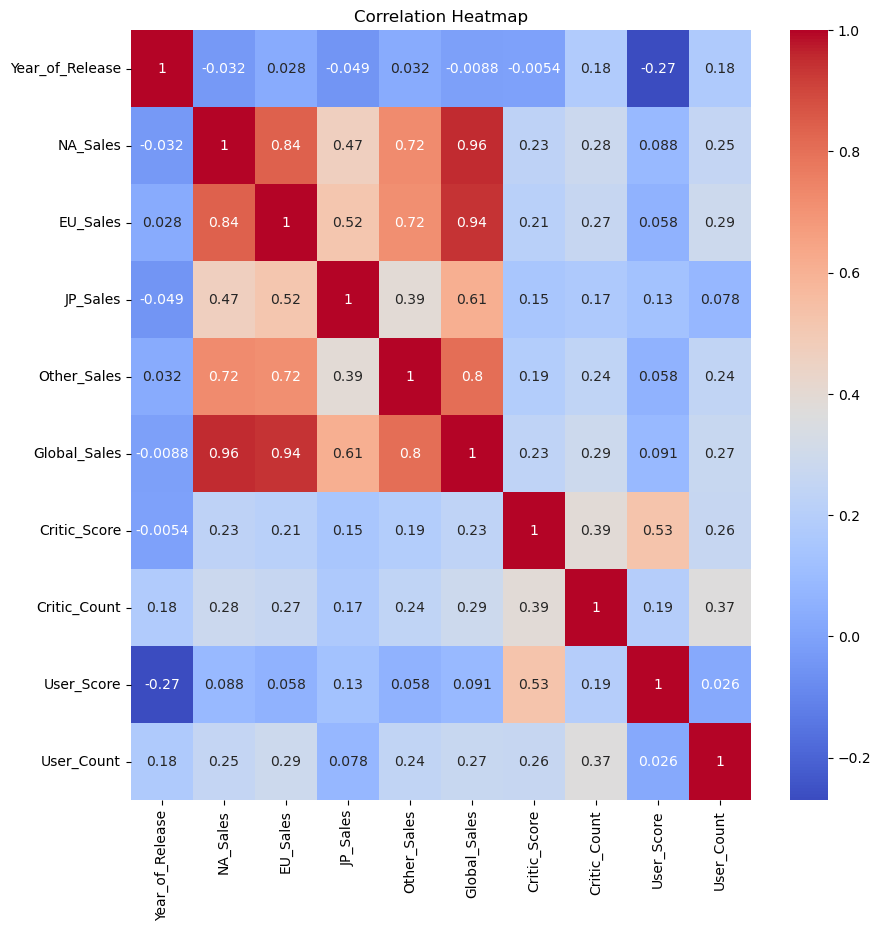

In [23]:
# Plot a heatmap of the correlation matrix using seaborn
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_data, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

#### Preprocessing

##### Handling Outliers

In [24]:
# Create a Winsorizer object
winsorizer = Winsorizer(capping_method='quantiles',  # Use quantile-based capping method
                        tail='both',  # Apply capping to both ends (1st and 99th percentiles)
                        fold=0.01,  # Capping values outside the 1st and 99th percentiles
                        variables=num_cols,  # Apply the transformation to the numerical columns
                        missing_values='ignore')  # Ignore missing values (NaN)

df = df_new.copy()

# Apply Winsorization to the numerical columns
df[num_cols] = winsorizer.fit_transform(df[num_cols])

##### Encoding

In [25]:
for i in cat_cols:
    print(df[i].value_counts(),'\n')

Name
Madden NFL 07                              9
LEGO Jurassic World                        9
LEGO Star Wars II: The Original Trilogy    9
Need for Speed: Most Wanted                9
LEGO Marvel Super Heroes                   8
                                          ..
Dragon Ball Z: Attack of the Saiyans       1
Monster Rancher 3                          1
Hamtaro: Ham-Ham Heartbreak                1
Okage: Shadow King                         1
15 Days                                    1
Name: count, Length: 4650, dtype: int64 

Platform
PS2     1239
X360     962
PS3      885
PC       761
XB       578
Wii      559
DS       516
PSP      423
GC       361
GBA      261
PS4      260
XOne     186
3DS      176
PS       163
PSV      143
WiiU     101
DC        14
Name: count, dtype: int64 

Genre
Action          1824
Sports          1102
Shooter          925
Role-Playing     747
Racing           639
Misc             437
Platform         434
Fighting         405
Simulation       343
Strat

In [26]:
# Mapping of platforms to more general categories
platform_mapping = {
    'PS2': 'Console',
    'X360': 'Console',
    'PS3': 'Console',
    'PC': 'PC-based',
    'XB': 'Console',
    'Wii': 'Console',
    'DS': 'Handheld',
    'PSP': 'Handheld',
    'GC': 'Console',
    'GBA': 'Handheld',
    'PS4': 'Console',
    'XOne': 'Console',
    '3DS': 'Handheld',
    'PS': 'Console',
    'PSV': 'Handheld',
    'WiiU': 'Console',
    'DC': 'Console'
}

# Add a new column with the generalized platform categories
df['Platform_Group'] = df['Platform'].map(platform_mapping)

In [27]:
df[df['Name']=="LEGO Jurassic World"]

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Platform_Group
2301,LEGO Jurassic World,PS4,2015,Action,Warner Bros. Interactive Entertainment,0.32,0.42,0.02,0.14,0.90,70.0,46.0,7.0,80.0,TT Games,E10+,Console
2402,LEGO Jurassic World,X360,2015,Action,Warner Bros. Interactive Entertainment,0.47,0.32,0.00,0.08,0.87,70.0,26.0,7.1,14.0,TT Games,E10+,Console
2435,LEGO Jurassic World,PS3,2015,Action,Warner Bros. Interactive Entertainment,0.35,0.36,0.00,0.14,0.85,70.0,26.0,7.4,14.0,TT Games,E10+,Console
3084,LEGO Jurassic World,XOne,2015,Action,Warner Bros. Interactive Entertainment,0.38,0.22,0.00,0.06,0.65,70.0,17.0,6.7,44.0,TT Games,E10+,Console
3230,LEGO Jurassic World,3DS,2015,Action,Warner Bros. Interactive Entertainment,0.31,0.23,0.03,0.05,0.62,70.0,26.0,7.2,11.0,TT Games,E10+,Handheld
3840,LEGO Jurassic World,WiiU,2015,Action,Warner Bros. Interactive Entertainment,0.27,0.19,0.02,0.04,0.52,71.0,5.0,8.1,14.0,TT Games,E10+,Console
7125,LEGO Jurassic World,PSV,2015,Action,Warner Bros. Interactive Entertainment,0.05,0.13,0.00,0.05,0.22,70.0,26.0,7.6,11.0,TT Games,E10+,Handheld
13942,LEGO Jurassic World,PC,2015,Action,Warner Bros. Interactive Entertainment,0.00,0.04,0.00,0.00,0.04,72.0,8.0,7.1,31.0,TT Games,E10+,PC-based
16825,LEGO Jurassic World,3DS,2015,Action,Warner Bros. Interactive Entertainment,0.31,0.23,0.03,0.05,0.62,70.0,26.0,7.2,11.0,TT Games,E10+,Handheld


We can see that there are multiple rows with the same game name, such as 'LEGO Jurassic World'. Therefore, we want to group the data by game name to consolidate it into a single row per game.

In [28]:
# Define the numeric and categorical columns
nums = ['Year_of_Release', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 
                'Global_Sales', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count']
cats = ['Platform', 'Genre', 'Publisher', 'Developer', 'Rating', 'Platform_Group']

# Group by 'Name' and aggregate using median for numeric and mode for categorical columns
df_cleaned = df.groupby('Name').agg(
    {**{col: 'median' for col in nums},  # Apply median for numeric columns
     **{col: lambda x: x.mode()[0] for col in cats}}  # Apply mode for categorical columns
).reset_index()

# Drop the 'Platform' column if it exists in the dataframe
df_cleaned = df_cleaned.drop(columns=['Platform'], errors='ignore')
df_ori = df_cleaned.copy()

In [29]:
df_cleaned.groupby('Name').size()[df_cleaned.groupby('Name').size() > 1].sort_values(ascending=False)

Series([], dtype: int64)

There is no more duplicate game name in the dataset, every game name in the dataset appears only once

In [30]:
# Define the columns to encode
ordinal_cols = ['Rating']
nominal_cols = ['Publisher', 'Developer']

In [31]:
df = df_cleaned.copy()

# List of all genres
genres_list = ['Action', 'Sports', 'Shooter', 'Role-Playing', 'Racing', 'Misc', 'Platform', 
               'Fighting', 'Simulation', 'Strategy', 'Adventure', 'Puzzle']

# Initialize new columns for one-hot encoding
for genre in genres_list:
    df[genre.lower()] = df['Genre'].apply(lambda x: 1 if genre.lower() in str(x).lower() else 0)

df = df.drop(columns=['Genre'])

df

,Name,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,...,shooter,role-playing,racing,misc,platform,fighting,simulation,strategy,adventure,puzzle
0,Tales of Xillia 2,2012.0,0.20,0.12,0.45,0.070,0.84,71.0,59.0,7.90,...,0,1,0,0,0,0,0,0,0,0
1,.hack//Infection Part 1,2002.0,0.49,0.38,0.26,0.130,1.27,75.0,35.0,8.50,...,0,1,0,0,0,0,0,0,0,0
2,.hack//Mutation Part 2,2002.0,0.23,0.18,0.20,0.060,0.68,76.0,24.0,8.90,...,0,1,0,0,0,0,0,0,0,0
3,.hack//Outbreak Part 3,2002.0,0.14,0.11,0.17,0.040,0.46,70.0,23.0,8.70,...,0,1,0,0,0,0,0,0,0,0
4,007 Racing,2000.0,0.30,0.20,0.00,0.030,0.53,51.0,16.0,4.60,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4645,inFAMOUS 2,2011.0,1.05,0.47,0.08,0.220,1.82,83.0,85.0,8.40,...,0,0,0,0,0,0,0,0,0,0
4646,inFAMOUS: Second Son,2014.0,1.28,0.98,0.07,0.460,2.79,80.0,85.0,7.90,...,0,0,0,0,0,0,0,0,0,0
4647,nail'd,2010.0,0.08,0.02,0.00,0.015,0.11,65.0,42.5,6.65,...,0,0,1,0,0,0,0,0,0,0
4648,pro evolution soccer 2011,2010.0,0.08,0.37,0.04,0.090,0.61,77.5,30.5,5.90,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# The ratings are assigned numbers from 1 to 7, based on their level of restriction or age suitability, with lower numbers corresponding to more general (age-appropriate) audiences
# and higher numbers indicating more restricted ratings

rating_mapping = {
    'EC': 1,
    'E': 2,
    'E10+': 3,
    'T': 4,
    'M': 5,
    'AO': 6,
    'RP': 7,
    'K-A': 2  # Same as 'E' for Kids to Adults
}

# Apply the mapping to the 'Rating' column
df['Rating'] = df['Rating'].map(rating_mapping)

In [33]:
# Use frequency encoding for nominal columns

for col in nominal_cols:
    freq_encoding = df[col].value_counts() / len(df)  # Frequency of each category
    df[col] = df[col].map(freq_encoding)  # Replace with frequency

df

,Name,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,...,shooter,role-playing,racing,misc,platform,fighting,simulation,strategy,adventure,puzzle
0,Tales of Xillia 2,2012.0,0.20,0.12,0.45,0.070,0.84,71.0,59.0,7.90,...,0,1,0,0,0,0,0,0,0,0
1,.hack//Infection Part 1,2002.0,0.49,0.38,0.26,0.130,1.27,75.0,35.0,8.50,...,0,1,0,0,0,0,0,0,0,0
2,.hack//Mutation Part 2,2002.0,0.23,0.18,0.20,0.060,0.68,76.0,24.0,8.90,...,0,1,0,0,0,0,0,0,0,0
3,.hack//Outbreak Part 3,2002.0,0.14,0.11,0.17,0.040,0.46,70.0,23.0,8.70,...,0,1,0,0,0,0,0,0,0,0
4,007 Racing,2000.0,0.30,0.20,0.00,0.030,0.53,51.0,16.0,4.60,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4645,inFAMOUS 2,2011.0,1.05,0.47,0.08,0.220,1.82,83.0,85.0,8.40,...,0,0,0,0,0,0,0,0,0,0
4646,inFAMOUS: Second Son,2014.0,1.28,0.98,0.07,0.460,2.79,80.0,85.0,7.90,...,0,0,0,0,0,0,0,0,0,0
4647,nail'd,2010.0,0.08,0.02,0.00,0.015,0.11,65.0,42.5,6.65,...,0,0,1,0,0,0,0,0,0,0
4648,pro evolution soccer 2011,2010.0,0.08,0.37,0.04,0.090,0.61,77.5,30.5,5.90,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# One-hot encodes the 'Platform_Group' column
df = pd.get_dummies(df, columns=['Platform_Group'], drop_first=True)
df

,Name,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,...,racing,misc,platform,fighting,simulation,strategy,adventure,puzzle,Platform_Group_Handheld,Platform_Group_PC-based
0,Tales of Xillia 2,2012.0,0.20,0.12,0.45,0.070,0.84,71.0,59.0,7.90,...,0,0,0,0,0,0,0,0,False,False
1,.hack//Infection Part 1,2002.0,0.49,0.38,0.26,0.130,1.27,75.0,35.0,8.50,...,0,0,0,0,0,0,0,0,False,False
2,.hack//Mutation Part 2,2002.0,0.23,0.18,0.20,0.060,0.68,76.0,24.0,8.90,...,0,0,0,0,0,0,0,0,False,False
3,.hack//Outbreak Part 3,2002.0,0.14,0.11,0.17,0.040,0.46,70.0,23.0,8.70,...,0,0,0,0,0,0,0,0,False,False
4,007 Racing,2000.0,0.30,0.20,0.00,0.030,0.53,51.0,16.0,4.60,...,1,0,0,0,0,0,0,0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4645,inFAMOUS 2,2011.0,1.05,0.47,0.08,0.220,1.82,83.0,85.0,8.40,...,0,0,0,0,0,0,0,0,False,False
4646,inFAMOUS: Second Son,2014.0,1.28,0.98,0.07,0.460,2.79,80.0,85.0,7.90,...,0,0,0,0,0,0,0,0,False,False
4647,nail'd,2010.0,0.08,0.02,0.00,0.015,0.11,65.0,42.5,6.65,...,1,0,0,0,0,0,0,0,False,False
4648,pro evolution soccer 2011,2010.0,0.08,0.37,0.04,0.090,0.61,77.5,30.5,5.90,...,0,0,0,0,0,0,0,0,False,False


In [35]:
# Function to get rows from df_ori for the recommended games, add a similarity score column, and sort by similarity score, while adding the original game as the first row with NaN similarity score

# Input: 
    # recommended_games - A list of tuples containing game names and their similarity scores
    # game_name - The name of the game to add as the first row with a NaN similarity score
# Process:  Filters rows from df_ori matching the recommended games, adds a similarity score column, and sorts by similarity score, including the specified game as the first row
# Output: A dataframe with the rows from df_ori corresponding to the recommended games, ordered by similarity score, with the specified game as the first row

def get_matching_rows_from_ori(recommended_games, game_name):
    # Extract the game names and similarity scores from the recommended_games list
    recommended_game_names = [game for game, _ in recommended_games]
    similarity_scores = [score for _, score in recommended_games]
    
    # Access the original dataframe df_ori (assuming it is globally defined)
    global df_ori
    
    # Filter df_ori for rows where the game name matches the recommended game names
    matching_rows = df_ori[df_ori['Name'].isin(recommended_game_names)].reset_index(drop=True)
    
    # Add a new column for the similarity score
    matching_rows['Similarity Score'] = matching_rows['Name'].map(dict(zip(recommended_game_names, similarity_scores)))
    
    # Sort by similarity score in descending order
    matching_rows = matching_rows.sort_values(by='Similarity Score', ascending=False).reset_index(drop=True)
    
    # Add the specified game as the first row with NaN similarity score
    game_row = df_ori[df_ori['Name'] == game_name].copy()
    game_row['Similarity Score'] = float('nan')  # Set the similarity score to NaN
    
    # Concatenate the game row at the top of the dataframe
    matching_rows = pd.concat([game_row, matching_rows], ignore_index=True)
    
    return matching_rows

### B. Content-Based Recommender System

In [36]:
# Define the genre columns
genre_columns = ['action', 'sports', 'shooter', 'role-playing', 'racing', 'misc', 'platform', 
                 'fighting', 'simulation', 'strategy', 'adventure', 'puzzle']

# Define the numeric columns
numeric_columns = ['Year_of_Release', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 
                   'Global_Sales', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count', 'Platform_Group_Handheld', 'Platform_Group_PC-based']

# Calculate cosine similarity based on genre (one-hot encoded columns)
genre_features = np.array(df[genre_columns])
genre_sim = cosine_similarity(genre_features, genre_features)

In [37]:
# Apply TF-IDF to the 'Name' column for name-based similarity
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Name'])
name_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [38]:
# Calculate cosine similarity for numeric columns
numeric_features = np.array(df[numeric_columns])
numeric_sim = cosine_similarity(numeric_features, numeric_features)

In [39]:
# Combine the similarities with appropriate weights
alpha = 0.20  # Weight for genre
beta = 0.05  # Weight for name
gamma = 0.75  # Weight for numeric features

# Combine the similarities: (alpha * genre_sim) + (beta * name_sim) + (gamma * numeric_sim)
final_sim = (alpha * genre_sim) + (beta * name_sim) + (gamma * numeric_sim)

In [40]:
# Function to get top N recommendations based on the combined similarity

# Input: game_name - The name of the game to find recommendations for, top_n - The number of top recommendations to return.
# Process: Computes similarity scores for the given game, sorts them in descending order, and selects the top_n most similar games.
# Output: A list of tuples with the top_n most similar game names and their respective similarity scores.

def get_recommendations_genre_name(game_name, top_n=5):
    """
    Recommend top_n games based on combined similarity (genre, name, and numeric features)
    """
    # Get the index of the game in the dataframe
    game_idx = df_cleaned[df_cleaned['Name'] == game_name].index[0]
    
    # Get the similarity scores for the given game
    sim_scores = list(enumerate(final_sim[game_idx]))
    
    # Sort the games by combined similarity score in descending order
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the top_n most similar games and their similarity scores
    top_similar_games = [(df_cleaned.iloc[i[0]]['Name'], i[1]) for i in sim_scores[1:top_n+1]]
    
    # Return the names and similarity scores of the recommended games
    return top_similar_games

### C. Evaluation

In [41]:
# Recommend games similar to "Cooking Mama"
recommended_games = get_recommendations_genre_name("Cooking Mama", top_n=5)
get_matching_rows_from_ori(recommended_games, "Cooking Mama")

,Name,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Genre,Publisher,Developer,Rating,Platform_Group,Similarity Score
0,Cooking Mama,2006.0,3.07,1.91,0.07,0.57,5.63,67.0,35.0,7.2,21.0,Simulation,505 Games,Taito Corporation,E,Handheld,NaN
1,Cooking Mama: Cook Off,2007.0,1.41,1.12,0.05,0.30,2.89,61.0,37.0,5.3,23.0,Simulation,505 Games,OfficeCreate,E,Console,0.989151
2,Cooking Mama: World Kitchen,2008.0,0.51,0.27,0.01,0.08,0.87,62.0,17.0,4.9,12.0,Simulation,505 Games,Cooking Mama Limited,E,Console,0.987262
3,Cooking Mama 4: Kitchen Magic!,2011.0,0.50,0.07,0.00,0.05,0.61,56.0,6.0,6.0,7.0,Simulation,505 Games,Cooking Mama Limited,E,Handheld,0.984814
4,Cooking Mama 2: Dinner With Friends,2007.0,1.60,1.49,0.10,0.39,3.58,70.0,39.0,8.0,9.0,Simulation,505 Games,Office Create,E,Handheld,0.983815
5,America's Test Kitchen: Let's Get Cooking,2010.0,0.25,0.00,0.00,0.02,0.26,87.0,4.0,5.6,9.0,Simulation,Nintendo,Indies Zero,E,Handheld,0.964850


The similarity score reflects how closely the recommended games align with "Cooking Mama" based on genre, name, and other relevant features. The score is calculated using cosine similarity, where a higher value indicates a closer match.

Similarity Scores:
1. Cooking Mama: Cook Off (0.989151): This game has the highest similarity score, indicating it closely matches the original "Cooking Mama." It is a direct sequel, sharing the same genre (Simulation), publisher (505 Games), and developer (OfficeCreate), and released on the same platform (Console).
2. Cooking Mama: World Kitchen (0.987262): This game also has a high similarity score, showing it is closely related to the original. Like the first game, it is a part of the Cooking Mama series, sharing similar game mechanics, genre, and publisher.
3. Cooking Mama 4: Kitchen Magic! (0.984814): This entry in the Cooking Mama series retains high similarity to the original game, with slight variations in sales figures and critic ratings, but still falls under the same genre (Simulation) and has similar platforms and publishers.
4. Cooking Mama 2: Dinner With Friends (0.983815): Similar to other Cooking Mama titles, this game ranks just slightly below the others in similarity, but it is still highly related in terms of genre and series continuation.
5. America's Test Kitchen: Let's Get Cooking (0.964850): While not a direct entry in the Cooking Mama series, it shares the Simulation genre and has a relatively high similarity score due to similar gameplay style and publisher (Nintendo), although it differs in developer and overall game concept.

Association:
- Platform: All the games in the top 5 recommendations are either on Console or Handheld, indicating that the original "Cooking Mama" is associated with family-friendly and portable gaming experiences.
- Genre: The Simulation genre is consistent across the recommended games, reflecting that "Cooking Mama" and its similar games fall under the same gameplay style that focuses on hands-on cooking simulation.
- Publisher & Developer: The Publisher for most of the recommended games is 505 Games, and several games share the same Developer as "Cooking Mama" (e.g., OfficeCreate and Cooking Mama Limited), reinforcing that these games belong to the same franchise or have a similar development background.

In [42]:
recommended_games = get_recommendations_genre_name("Call of Duty: Black Ops", top_n=5)
get_matching_rows_from_ori(recommended_games, "Call of Duty: Black Ops")

,Name,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Genre,Publisher,Developer,Rating,Platform_Group,Similarity Score
0,Call of Duty: Black Ops,2010.0,2.14065,1.4663,0.055,0.52065,4.260,83.5,41.5,6.15,590.5,Shooter,Activision,Treyarch,M,Console,NaN
1,Call of Duty 2,2005.0,0.91000,0.0450,0.005,0.08500,1.045,87.5,64.5,8.25,466.5,Shooter,Activision,Infinity Ward,T,Console,0.977562
2,Call of Duty: World at War,2008.0,1.17000,0.5800,0.000,0.18000,1.940,83.0,36.0,7.60,409.0,Shooter,Activision,Treyarch,M,Console,0.966900
3,Call of Duty: Black Ops II,2012.0,2.06065,1.5863,0.035,0.55565,4.340,82.0,26.0,5.05,1278.5,Shooter,Activision,Treyarch,M,Console,0.966735
4,Call of Duty: Infinite Warfare,2016.0,1.46000,0.7400,0.000,0.22000,2.420,77.0,17.0,3.10,440.0,Shooter,Activision,Infinity Ward,M,Console,0.963852
5,Spec Ops: The Line,2012.0,0.19000,0.1700,0.000,0.04000,0.420,76.0,27.0,8.20,350.0,Shooter,Take-Two Interactive,Yager,M,Console,0.960956


Similarity Scores:
1. Call of Duty 2 (0.977562): This game has the highest similarity score, indicating a strong association with "Call of Duty: Black Ops." It shares the same Shooter genre, Publisher (Activision), and Developer (Infinity Ward), and is released on the same platform (Console).
2. Call of Duty: World at War (0.966900): This game also shares similarities with the original, with the same genre, publisher (Activision), and developer (Treyarch). It’s also available on the Console platform and has a similar target audience.
3. Call of Duty: Black Ops II (0.966735): As a sequel to "Call of Duty: Black Ops," this game naturally shares many common features, including the Shooter genre, Publisher (Activision), and Developer (Treyarch), as well as being released on Console.
4. Call of Duty: Infinite Warfare (0.963852): This entry also shares the Shooter genre and Publisher (Activision) but is a newer game with some changes in mechanics and setting. It still has a very high similarity to the original game, with many features in common.
5. Spec Ops: The Line (0.960956): Although this game is not part of the "Call of Duty" series, it shares the Shooter genre and the Console platform, along with a similar rating and playstyle, making it a relevant recommendation despite some differences in gameplay and developer.

Association:
- Platform: The games in the top 5 are all on the Console platform, emphasizing that "Call of Duty: Black Ops" and its recommended games are primarily console-based experiences.
- Genre: The Shooter genre is consistent across all recommended games, showing that these games belong to the same gameplay category of first-person or third-person shooters.
- Publisher & Developer: Most of the recommended games are published by Activision and developed by either Treyarch or Infinity Ward, reinforcing the connection between these games in the "Call of Duty" franchise.

In [43]:
recommended_games = get_recommendations_genre_name("Mario Kart 7", top_n=5)
get_matching_rows_from_ori(recommended_games, "Mario Kart 7")

,Name,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Genre,Publisher,Developer,Rating,Platform_Group,Similarity Score
0,Mario Kart 7,2011.0,3.4813,2.4826,1.0913,0.9100,7.15,85.0,73.0,8.2,632.0,Racing,Nintendo,"Retro Studios, Entertainment Analysis & Develo...",E,Handheld,NaN
1,Mario Kart Wii,2008.0,3.4813,2.4826,1.0913,0.9213,7.15,82.0,73.0,8.3,709.0,Racing,Nintendo,Nintendo,E,Console,0.989707
2,Mario Kart DS,2005.0,3.4813,2.4826,1.0913,0.9213,7.15,91.0,64.0,8.6,464.0,Racing,Nintendo,Nintendo,E,Handheld,0.988800
3,Mario Kart: Super Circuit,2001.0,2.6200,1.6400,0.9900,0.2300,5.47,93.0,24.0,8.3,108.0,Racing,Nintendo,Intelligent Systems,E,Handheld,0.959931
4,Mario Kart 8,2014.0,3.1500,2.1500,1.0913,0.5100,7.09,88.0,82.0,9.1,1599.0,Racing,Nintendo,Nintendo,E,Console,0.950289
5,Forza Motorsport 4,2011.0,2.0800,1.9700,0.0600,0.4600,4.57,91.0,83.0,8.2,617.0,Racing,Microsoft Game Studios,Turn 10,E,Console,0.949970


Similarity Scores:
1. Mario Kart Wii (0.989707): This game shares the same Racing genre and Publisher (Nintendo), with similar gameplay and platform (Console), making it the closest match to "Mario Kart 7."
2. Mario Kart DS (0.988800): Also from Nintendo, this game shares the Racing genre and Platform (Handheld), offering a very similar experience to "Mario Kart 7."
3. Mario Kart: Super Circuit (0.959931): Another Nintendo game in the Racing genre, with some differences in gameplay and platform (Handheld), but still highly similar to "Mario Kart 7."
4. Mario Kart 8 (0.950289): A more recent entry in the Mario Kart series, available on Console, with a lower similarity score due to some differences in gameplay mechanics but still closely related.
5. Forza Motorsport 4 (0.949970): Although not part of the Mario Kart series, this Racing game shares similarities in terms of genre and platform (Console), though it's more of a simulation-based racing game compared to the arcade-style gameplay of "Mario Kart."

Association:
- Platform: The majority of the recommended games are for the Handheld or Console platform, showing that "Mario Kart 7" and its recommended games are mostly available on these platforms.
- Genre: The Racing genre is consistent across all recommended games, indicating a shared focus on racing gameplay.
- Publisher: All games except "Forza Motorsport 4" are published by Nintendo, underscoring the strong connection within the Mario Kart series and other Nintendo racing games.
